Всего строк: 28499
Пример строк:
   sample         annotation
0      aa        [[0, 2, O]]
1    aala        [[0, 4, O]]
2  aarcca        [[0, 6, O]]
3    abon        [[0, 4, O]]
4    abso  [[0, 4, B-BRAND]]
Запросов без сущностей: 733 (2.57%)
Средняя длина запроса (символы): 10.596582336222324
Средняя длина запроса (слова): 1.602407102003579
Распределение сущностей по типам (включая O):
O: 5375
BRAND: 7792
TYPE: 30220
PERCENT: 415
VOLUME: 949


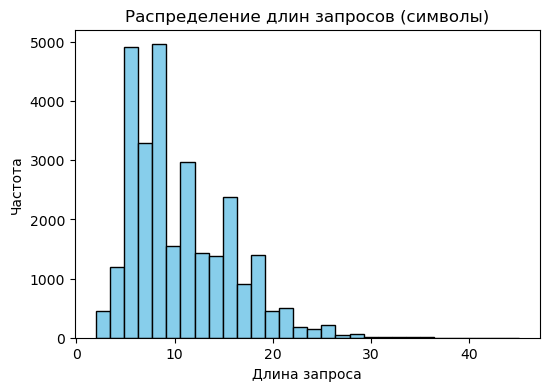

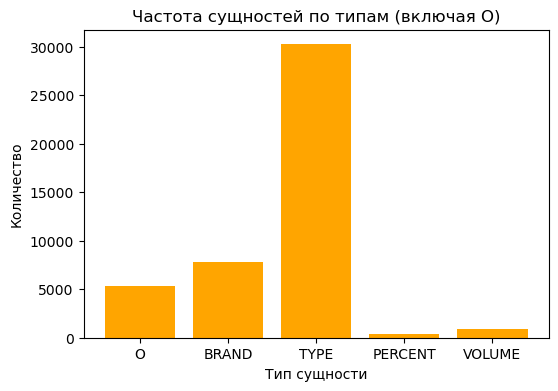

Примеры с PERCENT:
                                 sample  \
3020                          балтика 0   
8891                           кефир 1%   
12560                масло сливочное 72   
12561                масло сливочное 82   
13167                        молоко 1 %   
13169                        молоко 3,2   
13225  молоко ультрапастеризованное 3.2   
13973                  мягкий творог 5%   
20351                         сливки 10   
20352                        сливки 10%   

                                              annotation  len_chars  len_words  
3020                [[0, 7, B-BRAND], [8, 9, B-PERCENT]]          9          2  
8891                 [[0, 5, B-TYPE], [6, 8, B-PERCENT]]          8          2  
12560  [[0, 5, B-TYPE], [6, 15, I-TYPE], [16, 18, B-P...         18          3  
12561  [[0, 5, B-TYPE], [6, 15, I-TYPE], [16, 18, B-P...         18          3  
13167  [[0, 6, B-TYPE], [7, 8, B-PERCENT], [9, 10, I-...         10          3  
13169               [

In [13]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
from collections import Counter

# === 1. Загружаем данные ===
df = pd.read_csv(
    r"C:\Users\Vito\1_million\train_clean_aug.csv",
    sep=";", 
    encoding="utf-8"
)

# Преобразуем annotation из строки в список кортежей
df["annotation"] = df["annotation"].apply(ast.literal_eval)

print("Всего строк:", len(df))
print("Пример строк:")
print(df.head())

# === 2. Общая статистика ===
# Доля пустых примеров (где все O)
empty_mask = df["annotation"].apply(lambda x: all(tag == "O" for _, _, tag in x))
print("Запросов без сущностей:", empty_mask.sum(), f"({empty_mask.mean()*100:.2f}%)")

# Длина запроса в символах и словах
df["len_chars"] = df["sample"].str.len()
df["len_words"] = df["sample"].str.split().apply(len)

print("Средняя длина запроса (символы):", df["len_chars"].mean())
print("Средняя длина запроса (слова):", df["len_words"].mean())

# === 3. Подсчёт сущностей по типам (включая O) ===
all_entities = []
for spans in df["annotation"]:
    for (_, _, tag) in spans:
        # оставляем все метки, включая O
        if tag == "O":
            all_entities.append("O")
        else:
            ent_type = tag.split("-")[-1]  # TYPE, BRAND, VOLUME, PERCENT
            all_entities.append(ent_type)

entity_counts = Counter(all_entities)
print("Распределение сущностей по типам (включая O):")
for ent, cnt in entity_counts.items():
    print(f"{ent}: {cnt}")

# === 4. Визуализации ===
plt.figure(figsize=(6,4))
plt.hist(df["len_chars"], bins=30, color="skyblue", edgecolor="black")
plt.title("Распределение длин запросов (символы)")
plt.xlabel("Длина запроса")
plt.ylabel("Частота")
plt.show()

plt.figure(figsize=(6,4))
plt.bar(entity_counts.keys(), entity_counts.values(), color="orange")
plt.title("Частота сущностей по типам (включая O)")
plt.xlabel("Тип сущности")
plt.ylabel("Количество")
plt.show()

# === 5. Примеры с редкими сущностями (например, PERCENT) ===
examples_percent = df[df["annotation"].apply(lambda spans: any("PERCENT" in t for _, _, t in spans))]
print("Примеры с PERCENT:")
print(examples_percent.head(10))

In [13]:
import pandas as pd
import ast
import re

# === 1. Загружаем данные ===
df = pd.read_csv(
    r"C:\Users\Vito\1_million\train.csv",
    sep=";", 
    encoding="utf-8"
)
df["annotation"] = df["annotation"].apply(ast.literal_eval)

# === 2. Регулярки для поиска ===
volume_re = re.compile(r"\d+(?:[.,]\d+)?\s*(мл|л|г|гр|кг|шт)", flags=re.I)
percent_re = re.compile(r"\d+(?:[.,]\d+)?\s*(%|проц(?:\.|ент)?)", flags=re.I)

# === 3. Вытаскиваем размеченные сущности ===
def extract_entities(row, target_type):
    text = row["sample"]
    ents = []
    for (start, end, tag) in row["annotation"]:
        if target_type in tag:  # B-VOLUME / I-VOLUME / B-PERCENT / I-PERCENT
            ents.append(text[start:end])
    return ents

all_volume = sum(df.apply(lambda r: extract_entities(r, "VOLUME"), axis=1), [])
all_percent = sum(df.apply(lambda r: extract_entities(r, "PERCENT"), axis=1), [])

uniq_volume = set(all_volume)
uniq_percent = set(all_percent)

print(f"Всего размечено VOLUME: {len(all_volume)}, уникальных: {len(uniq_volume)}")
print(f"Всего размечено PERCENT: {len(all_percent)}, уникальных: {len(uniq_percent)}")

# === 4. Проверка покрытия regex ===
def covered_by_regex(values, regex):
    covered = [v for v in values if regex.fullmatch(v.strip())]
    not_covered = [v for v in values if not regex.fullmatch(v.strip())]
    return covered, not_covered

vol_covered, vol_not = covered_by_regex(uniq_volume, volume_re)
perc_covered, perc_not = covered_by_regex(uniq_percent, percent_re)

print("\n--- VOLUME ---")
print("Покрыто regex:", len(vol_covered), "/", len(uniq_volume), f"({len(vol_covered)/len(uniq_volume)*100:.2f}%)")
print("Не покрыто regex:", vol_not)

print("\n--- PERCENT ---")
print("Покрыто regex:", len(perc_covered), "/", len(uniq_percent), f"({len(perc_covered)/len(uniq_percent)*100:.2f}%)")
print("Не покрыто regex:", perc_not)

# === 5. Выводим примеры ===
print("\nПримеры уникальных VOLUME:", list(uniq_volume)[:20])
print("\nПримеры уникальных PERCENT:", list(uniq_percent)[:20])


Всего размечено VOLUME: 84, уникальных: 36
Всего размечено PERCENT: 30, уникальных: 19

--- VOLUME ---
Покрыто regex: 6 / 36 (16.67%)
Не покрыто regex: ['литров', 'пять', 'объём', 'гр', '30', 'л', '12', '25', 'кг', '0.5', '3', '2', '225', '1', '90', 'большой', '0,2', '1,5', '5', 'штук', '60', '21', '10', '5л.', 'литра', '5литров', 'л.', '7', '8', 'литр']

--- PERCENT ---
Покрыто regex: 6 / 19 (31.58%)
Не покрыто regex: ['9', '0', '25', '3', '20', '33', '1', '%', '72', '10', '82', '3,2', '3.2']

Примеры уникальных VOLUME: ['литров', 'пять', 'объём', 'гр', '30', 'л', '12', '25', 'кг', '0.5', '3', '3кг', '2', '225', '1', '90', 'большой', '0,2', '5л', '2л']

Примеры уникальных PERCENT: ['9', '0', '25', '3', '20', '10%', '5%', '33', '15%', '1', '1%', '%', '20%', '72', '10', '82', '3,2', '3.2', '33%']


Всего строк: 27244
Пример строк:
   sample         annotation
0      aa        [[0, 2, O]]
1    aala        [[0, 4, O]]
2  aarcca        [[0, 6, O]]
3    abon        [[0, 4, O]]
4    abso  [[0, 4, B-BRAND]]
Запросов без сущностей: 733 (2.69%)
Средняя длина запроса (символы): 10.367603876082807
Средняя длина запроса (слова): 1.5504698282190574
Распределение сущностей по типам:
BRAND: 7696
TYPE: 29056
PERCENT: 30
VOLUME: 84


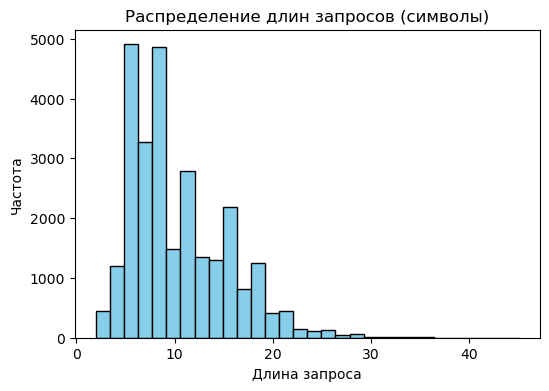

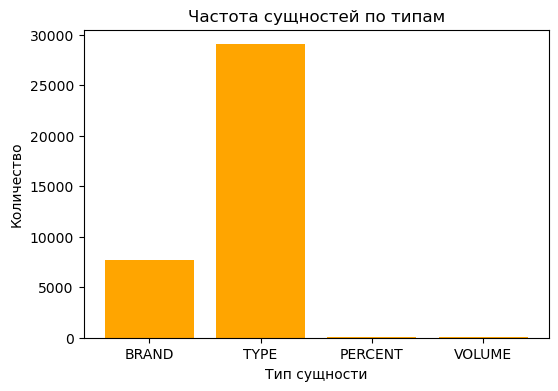

Примеры с PERCENT:
                                 sample  \
3020                          балтика 0   
8891                           кефир 1%   
12560                масло сливочное 72   
12561                масло сливочное 82   
13167                        молоко 1 %   
13169                        молоко 3,2   
13225  молоко ультрапастеризованное 3.2   
13973                  мягкий творог 5%   
20351                         сливки 10   
20352                        сливки 10%   

                                              annotation  len_chars  len_words  
3020                [[0, 7, B-BRAND], [8, 9, B-PERCENT]]          9          2  
8891                 [[0, 5, B-TYPE], [6, 8, B-PERCENT]]          8          2  
12560  [[0, 5, B-TYPE], [6, 15, I-TYPE], [16, 18, B-P...         18          3  
12561  [[0, 5, B-TYPE], [6, 15, I-TYPE], [16, 18, B-P...         18          3  
13167  [[0, 6, B-TYPE], [7, 8, B-PERCENT], [9, 10, I-...         10          3  
13169               [

In [11]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
from collections import Counter

# === 1. Загружаем данные ===
df = pd.read_csv(
    r"C:\Users\Vito\1_million\train_clean.csv",
    sep=";", 
    encoding="utf-8"
)

# Преобразуем annotation из строки в список кортежей
df["annotation"] = df["annotation"].apply(ast.literal_eval)

print("Всего строк:", len(df))
print("Пример строк:")
print(df.head())

# === 2. Общая статистика ===
# Доля пустых примеров (где все O)
empty_mask = df["annotation"].apply(lambda x: all(tag.endswith("O") for _, _, tag in x))
print("Запросов без сущностей:", empty_mask.sum(), f"({empty_mask.mean()*100:.2f}%)")

# Длина запроса в символах и словах
df["len_chars"] = df["sample"].str.len()
df["len_words"] = df["sample"].str.split().apply(len)

print("Средняя длина запроса (символы):", df["len_chars"].mean())
print("Средняя длина запроса (слова):", df["len_words"].mean())

# === 3. Подсчёт сущностей по типам ===
all_entities = []
for spans in df["annotation"]:
    for (_, _, tag) in spans:
        if tag != "O":
            # отрезаем B-/I-
            ent_type = tag.split("-")[-1]
            all_entities.append(ent_type)

entity_counts = Counter(all_entities)
print("Распределение сущностей по типам:")
for ent, cnt in entity_counts.items():
    print(f"{ent}: {cnt}")

# === 4. Визуализации ===
plt.figure(figsize=(6,4))
plt.hist(df["len_chars"], bins=30, color="skyblue", edgecolor="black")
plt.title("Распределение длин запросов (символы)")
plt.xlabel("Длина запроса")
plt.ylabel("Частота")
plt.show()

plt.figure(figsize=(6,4))
plt.bar(entity_counts.keys(), entity_counts.values(), color="orange")
plt.title("Частота сущностей по типам")
plt.xlabel("Тип сущности")
plt.ylabel("Количество")
plt.show()

# === 5. Примеры с редкими сущностями (например, PERCENT) ===
examples_percent = df[df["annotation"].apply(lambda spans: any("PERCENT" in t for _, _, t in spans))]
print("Примеры с PERCENT:")
print(examples_percent.head(10))

In [76]:
PRODUCT_ATTRS = {
    # Бренды
    "балтика": {
        "PERCENT": ["0", "3", "5", "7", "9"],   # сорта пива
        "PERCENT_UNITS": [""],             # как пишут в запросах
    },
    "святой источник": {
        "VOLUME": ["0.5", "1", "1.5", "2", "5"],
        "VOLUME_UNITS": ["л", "литр", "литра", "литров", ""]
    },
    "фрутоняня": {
        "VOLUME": ["90", "200", "500"],
        "VOLUME_UNITS": ["грамм", "г", "мл", ""]
    },
    "ясно солнышко": {
        "VOLUME": ["1", "2"],   # номер линейки
        "VOLUME_UNITS": [""]
    },

    # Напитки
    "вода": {
        "VOLUME": ["0.33", "0.5", "1", "1.5", "2", "5", "6", "10", "12", "20"],
        "VOLUME_UNITS": ["л", "литр", "литра", "литров", ""],
        "BRAND": ["шишкин лес", "красная цена", ""]
    },
    "газированная вода": {
        "VOLUME": ["0.5", "1", "1.5", "2"],
        "VOLUME_UNITS": ["л", "литр", "литра", "литров", ""]
    },
    "газировка": {
        "VOLUME": ["0.5", "1", "1.5", "2"],
        "VOLUME_UNITS": ["л", "литр", "литра", "литров", ""]
    },
    "сок": {
        "VOLUME": ["0.2", "0.5", "1", "1.5", "2"],
        "VOLUME_UNITS": ["л", "литр", "литра", "литров", ""],
        "BRAND": ["global", "j", "сады придонья", ""]
    },
    "кола": {
        "VOLUME": ["0.5", "1", "1.5", "2"],
        "VOLUME_UNITS": ["л", "литр", "литра", "литров", ""]
    },

    # Молочные продукты
    "молоко": {
        "PERCENT": ["0", "0.5", "1", "1.5", "2", "2.5", "3", "3.2", "3.5", "3.6", "4"],
        "PERCENT_UNITS": ["%", "процент", "процента", "процентов", "проц"],
        "VOLUME": ["0.2", "0.5", "1", "1.5", "2", "3"],
        "VOLUME_UNITS": ["л", "литр", "литра", "литров", ""]
    },
    "кефир": {
        "PERCENT": ["1", "2.5", "3.2", "3.5", "4"],
        "PERCENT_UNITS": ["%", "процент", "процента", "процентов", "проц", ""]
    },
    "йогурт": {
        "VOLUME": ["100", "125", "200", "330", "1000"],
        "VOLUME_UNITS": ["г", "мл", "", "грамм"]
    },
    "масло сливочное": {
        "PERCENT": ["72", "73", "82"],
        "PERCENT_UNITS": ["%", ""]
    },
    "сливки": {
        "PERCENT": ["10", "15", "20", "33", "35"],
        "PERCENT_UNITS": ["%", "процент", "процента", ""]
    },
    "сметана": {
        "PERCENT": ["10", "15", "20", "25", "30"],
        "PERCENT_UNITS": ["%", "процент", "процента", ""]
    },
    "творог": {
        "PERCENT": ["1", "2", "5", "9"],
        "PERCENT_UNITS": ["%", "процент", "процента", ""],
        "VOLUME": ["200", "250", "400", "500", "1000"],
        "VOLUME_UNITS": ["г", "грамм"]
    },
    "сыр легкий": {
        "PERCENT": ["15", "17"],
        "PERCENT_UNITS": ["%", "процент", "процента", ""],
        "VOLUME": ["200", "250", "400", "500", "1000"],
        "VOLUME_UNITS": ["г", "грамм"]
    },
    "молочный коктейль": {
        "VOLUME": ["200", "500", "1000"],
        "VOLUME_UNITS": ["мл"]
    },

    # Базовые продукты
    "сахар": {
        "VOLUME": ["500", "1000", "2000", "3000", "5000"],
        "VOLUME_UNITS": ["г", "грамм"]
    },
    "яйца": {
        "VOLUME": ["6", "10", "12", "20", "30", "десяток"],
        "VOLUME_UNITS": ["штук", "шт", ""]
    },
    "яйцо куриное": {
        "VOLUME": ["6", "10", "12", "20", "30"],
        "VOLUME_UNITS": ["шт", "штук", ""]
    },
    "чипсы": {
        "VOLUME": ["50", "100", "150", "225"],
        "VOLUME_UNITS": ["г"]
    },
    "чай черный": {
        "VOLUME": ["20", "25", "50", "100"],
        "VOLUME_UNITS": ["пакетиков", "шт"]
    },

    # Хозтовары
    "бумага туалетная": {
        "VOLUME": ["4", "8", "12", "16"],
        "VOLUME_UNITS": ["рулонов", "шт", "рулона"]
    },
    "туалетная бумага": {
        "VOLUME": ["4", "8", "12", "16"],
        "VOLUME_UNITS": ["рулонов", "шт", "рулона"]
    },
    "пакеты": {
        "VOLUME": ["30", "60", "120"],
        "VOLUME_UNITS": ["л", "литр", "литра", "литров", ""]
    },
    "мешки": {
        "VOLUME": ["30", "60", "120"],
        "VOLUME_UNITS": ["л", "литр", "литра", "литров", ""]
    },
    "мешки для мусора": {
        "VOLUME": ["30", "60", "120"],
        "VOLUME_UNITS": ["л", "литр", "литра", "литров", ""]
    },
    "стиральный порошок": {
        "VOLUME": ["1000", "2000", "3000", "5000"],
        "VOLUME_UNITS": ["г", "грамм"]
    },

    # Смеси
    "смесь нан": {
        "VOLUME": ["1", "2", "3", "4"],
        "VOLUME_UNITS": [""]
    },
    "смесь нестожен": {
        "VOLUME": ["1", "2"],
        "VOLUME_UNITS": [""],
        "PERCENT": ["3"],   # линейка
        "PERCENT_UNITS": [""]
    },

    # Сосиски
    "сосиски венские": {
        "VOLUME": ["300", "500", "800", "1000"],
        "VOLUME_UNITS": ["г", "грамм"]
    },
}

In [81]:
# -*- coding: utf-8 -*-
import re
import pandas as pd

# === утилиты ===
WS_TOKEN_RE = re.compile(r"\S+")

def token_spans(segment: str, base_start: int, ent_type: str):
    """BIO-разметка по токенам (каждый токен отдельный спан)."""
    spans = []
    for i, m in enumerate(WS_TOKEN_RE.finditer(segment)):
        s = base_start + m.start()
        e = base_start + m.end()
        tag = f"{'B' if i == 0 else 'I'}-{ent_type}"
        spans.append((s, e, tag))
    return spans

def normalize_number(num: str):
    variants = {num}
    if "." in num: variants.add(num.replace(".", ","))
    if "," in num: variants.add(num.replace(",", "."))
    return list(variants)

def combine_with_units(base: str, units: list):
    out = set()
    for u in units:
        if u == "":
            out.add(base)
        else:
            out.add(base + u)
            out.add(base + " " + u)
    return list(out)

def make_bio(sample: str, product: str, product_label: str,
             value: str = None, value_label: str = None,
             brand: str = None):
    anns = []
    pos = 0

    # product (TYPE или BRAND)
    anns.extend(token_spans(product, pos, product_label))
    pos += len(product)

    if brand:
        pos += 1  # пробел
        anns.extend(token_spans(brand, pos, "BRAND"))
        pos += len(brand)

    if value:
        pos += 1  # пробел
        anns.extend(token_spans(value, pos, value_label))
    return anns

def generate_dataset(product_attrs: dict, brand_keys=None) -> pd.DataFrame:
    if brand_keys is None:
        brand_keys = {"балтика", "святой источник", "фрутоняня", "ясно солнышко"}

    rows = []
    for product, attrs in product_attrs.items():
        product_label = "BRAND" if product in brand_keys else "TYPE"

        # --- PERCENT ---
        if "PERCENT" in attrs:
            for val in attrs["PERCENT"]:
                for vnum in normalize_number(val):
                    for vfull in combine_with_units(vnum, attrs.get("PERCENT_UNITS", [])):
                        sample = f"{product} {vfull}"
                        anns = make_bio(sample, product, product_label, vfull, "PERCENT")
                        rows.append({"sample": sample, "annotation": anns})

        # --- VOLUME ---
        if "VOLUME" in attrs:
            for val in attrs["VOLUME"]:
                for vnum in normalize_number(val):
                    for vfull in combine_with_units(vnum, attrs.get("VOLUME_UNITS", [])):
                        sample = f"{product} {vfull}"
                        anns = make_bio(sample, product, product_label, vfull, "VOLUME")
                        rows.append({"sample": sample, "annotation": anns})

        # --- c BRAND внутри TYPE ---
        if "BRAND" in attrs:
            for b in attrs["BRAND"]:
                if b == "":  # пустая строка
                    continue
                # без значения
                sample = f"{product} {b}"
                anns = make_bio(sample, product, "TYPE", None, None, b)
                rows.append({"sample": sample, "annotation": anns})

                # с volume
                if "VOLUME" in attrs:
                    for val in attrs["VOLUME"]:
                        for vnum in normalize_number(val):
                            for vfull in combine_with_units(vnum, attrs.get("VOLUME_UNITS", [])):
                                sample = f"{product} {b} {vfull}"
                                anns = make_bio(sample, product, "TYPE", vfull, "VOLUME", b)
                                rows.append({"sample": sample, "annotation": anns})

    return pd.DataFrame(rows)


# === генерация ===
df_aug = generate_dataset(PRODUCT_ATTRS)

print("Пример 10 строк:")
print(df_aug.sample(10))

df_aug.to_csv("augmented_dataset.csv", sep=";", index=False, encoding="utf-8-sig")
print(f"✅ Сохранено {len(df_aug)} строк в augmented_dataset.csv")

Пример 10 строк:
                        sample  \
561              сок 0.2литров   
293     вода шишкин лес 6литра   
1002           молоко 3.2 проц   
1129              молоко 1.5 л   
1227                   кефир 4   
893                кола 2 литр   
1484              яйца десяток   
184              вода 10 литра   
815   сок сады придонья 1 литр   
1200        кефир 3,2 процента   

                                             annotation  
561                 [(0, 3, B-TYPE), (4, 13, B-VOLUME)]  
293   [(0, 4, B-TYPE), (5, 11, B-BRAND), (12, 15, I-...  
1002  [(0, 6, B-TYPE), (7, 10, B-PERCENT), (11, 15, ...  
1129  [(0, 6, B-TYPE), (7, 10, B-VOLUME), (11, 12, I...  
1227                [(0, 5, B-TYPE), (6, 7, B-PERCENT)]  
893   [(0, 4, B-TYPE), (5, 6, B-VOLUME), (7, 11, I-V...  
1484                [(0, 4, B-TYPE), (5, 12, B-VOLUME)]  
184   [(0, 4, B-TYPE), (5, 7, B-VOLUME), (8, 13, I-V...  
815   [(0, 3, B-TYPE), (4, 8, B-BRAND), (9, 17, I-BR...  
1200  [(0, 5, B-TYPE), (6, 9

In [82]:
df_aug

,sample,annotation
0,балтика 0,"[(0, 7, B-BRAND), (8, 9, B-PERCENT)]"
1,балтика 3,"[(0, 7, B-BRAND), (8, 9, B-PERCENT)]"
2,балтика 5,"[(0, 7, B-BRAND), (8, 9, B-PERCENT)]"
3,балтика 7,"[(0, 7, B-BRAND), (8, 9, B-PERCENT)]"
4,балтика 9,"[(0, 7, B-BRAND), (8, 9, B-PERCENT)]"
...,...,...
1700,сосиски венские 800 г,"[(0, 7, B-TYPE), (8, 15, I-TYPE), (16, 19, B-V..."
1701,сосиски венские 1000 грамм,"[(0, 7, B-TYPE), (8, 15, I-TYPE), (16, 20, B-V..."
1702,сосиски венские 1000 г,"[(0, 7, B-TYPE), (8, 15, I-TYPE), (16, 20, B-V..."
1703,сосиски венские 1000грамм,"[(0, 7, B-TYPE), (8, 15, I-TYPE), (16, 25, B-V..."


In [24]:
import itertools
import pandas as pd

# === Нормализаторы ===
def normalize_number(num: str):
    """Меняет точку и запятую."""
    variants = {num}
    if "." in num:
        variants.add(num.replace(".", ","))
    if "," in num:
        variants.add(num.replace(",", "."))
    return list(variants)

def combine_with_units(base: str, units: list):
    """Создаём варианты с юнитами, с пробелом и без."""
    variants = []
    for u in units:
        if u == "":
            variants.append(base)
        else:
            variants.append(base + u)
            variants.append(base + " " + u)
    return list(set(variants))

def make_bio(sample: str, entities: list):
    """
    Строим BIO разметку.
    entities = [(substring, label)]
    """
    anns = []
    for substr, label in entities:
        start = sample.index(substr)
        end = start + len(substr)
        anns.append((start, end, f"B-{label}"))
    return anns


def generate_dataset(product_attrs: dict):
    rows = []

    # список брендов для TYPE/BRAND различения
    brand_products = {"балтика", "святой источник", "фрутоняня", "ясно солнышко"}

    for product, attrs in product_attrs.items():
        # определяем, бренд это или тип
        product_label = "BRAND" if product in brand_products else "TYPE"

        # --- PERCENT ---
        if "PERCENT" in attrs:
            for val in attrs["PERCENT"]:
                for norm_val in normalize_number(val):
                    for full_val in combine_with_units(norm_val, attrs.get("PERCENT_UNITS", [])):
                        sample = f"{product} {full_val}".strip()
                        entities = [(product, product_label), (full_val, "PERCENT")]
                        anns = make_bio(sample, entities)
                        rows.append({"sample": sample, "annotation": anns})

        # --- VOLUME ---
        if "VOLUME" in attrs:
            for val in attrs["VOLUME"]:
                for norm_val in normalize_number(val):
                    for full_val in combine_with_units(norm_val, attrs.get("VOLUME_UNITS", [])):
                        sample = f"{product} {full_val}".strip()
                        entities = [(product, product_label), (full_val, "VOLUME")]
                        anns = make_bio(sample, entities)
                        rows.append({"sample": sample, "annotation": anns})

        # --- BRAND (вложенные бренды внутри продукта, напр. "вода шишкин лес") ---
        if "BRAND" in attrs:
            for b in attrs["BRAND"]:
                if not b:  # пустая строка — пропускаем
                    continue
                sample = f"{product} {b}"
                entities = [(product, product_label), (b, "BRAND")]
                anns = make_bio(sample, entities)
                rows.append({"sample": sample, "annotation": anns})

        # --- OTHER (например, "без сахара" у колы) ---
        if "OTHER" in attrs:
            for oth in attrs["OTHER"]:
                sample = f"{product} {oth}".strip()
                entities = [(product, product_label)]
                anns = make_bio(sample, entities)
                rows.append({"sample": sample, "annotation": anns})

    return pd.DataFrame(rows)


# === Генерация ===
df_aug = generate_dataset(PRODUCT_ATTRS)

print("Пример 10 строк:")
print(df_aug.sample(10))

df_aug.to_csv("augmented_dataset.csv", sep=";", index=False, encoding="utf-8")
print(f"Сохранено {len(df_aug)} строк в augmented_dataset.csv")

Пример 10 строк:
                          sample                              annotation
693              молоко 3 литров     [(0, 6, B-TYPE), (7, 15, B-VOLUME)]
619            молоко 0,2 литров     [(0, 6, B-TYPE), (7, 17, B-VOLUME)]
7     святой источник 0,5 литров  [(0, 15, B-BRAND), (16, 26, B-VOLUME)]
1002                 сахар 3000г     [(0, 5, B-TYPE), (6, 11, B-VOLUME)]
74                 фрутоняня 90г   [(0, 9, B-BRAND), (10, 13, B-VOLUME)]
909            творог 2 процента    [(0, 6, B-TYPE), (7, 17, B-PERCENT)]
1072     чай черный 20 пакетиков   [(0, 10, B-TYPE), (11, 23, B-VOLUME)]
1108      бумага туалетная 16 шт   [(0, 16, B-TYPE), (17, 22, B-VOLUME)]
923            творог 9 процента    [(0, 6, B-TYPE), (7, 17, B-PERCENT)]
1149                 пакеты 60 л     [(0, 6, B-TYPE), (7, 11, B-VOLUME)]
Сохранено 1255 строк в augmented_dataset.csv


In [25]:
df_aug.head(50)

,sample,annotation
0,балтика 0,"[(0, 7, B-BRAND), (8, 9, B-PERCENT)]"
1,балтика 3,"[(0, 7, B-BRAND), (8, 9, B-PERCENT)]"
2,балтика 5,"[(0, 7, B-BRAND), (8, 9, B-PERCENT)]"
3,балтика 7,"[(0, 7, B-BRAND), (8, 9, B-PERCENT)]"
4,балтика 9,"[(0, 7, B-BRAND), (8, 9, B-PERCENT)]"
5,"святой источник 0,5","[(0, 15, B-BRAND), (16, 19, B-VOLUME)]"
6,"святой источник 0,5 л","[(0, 15, B-BRAND), (16, 21, B-VOLUME)]"
7,"святой источник 0,5 литров","[(0, 15, B-BRAND), (16, 26, B-VOLUME)]"
8,"святой источник 0,5 литр","[(0, 15, B-BRAND), (16, 24, B-VOLUME)]"
9,"святой источник 0,5 литра","[(0, 15, B-BRAND), (16, 25, B-VOLUME)]"


In [31]:
df.to_excel("augmented_dataset.xlsx", index=False, engine="openpyxl")

In [87]:
# -*- coding: utf-8 -*-
import re
import pandas as pd

# --- Настройка источников: только соки и вода (обычная/газированная/газировка)
PRODUCT_ATTRS = {
    "сок": {
        "VOLUME": ["0.2", "0,2", "0.5", "0,5", "1", "1.5", "1,5", "2"],
        "VOLUME_UNITS": ["л", "литр", "литра", "литров"],
        "TYPES": ["яблочный", "апельсиновый", "виноградный", "томатный"]
    },
    "вода": {
        "VOLUME": ["0.33", "0,33", "0.5", "0,5", "1", "1.5", "1,5", "2", "5"],
        "VOLUME_UNITS": ["л", "литр", "литра", "литров"],
        "TYPES": ["газированная", "негазированная", "минеральная"]
    },
    "вода": {
        "VOLUME": ["0.5", "0,5", "1", "1.5", "1,5", "2"],
        "VOLUME_UNITS": ["л", "литр", "литра", "литров"],
        "TYPES": ["газированная", "негазированная"]
    },
    "газировка": {
        "VOLUME": ["0.5", "0,5", "1", "1.5", "1,5", "2"],
        "VOLUME_UNITS": ["л", "литр", "литра", "литров"],
        "TYPES": ["лимонная", "апельсиновая"]
    }
}

NONSPACE = re.compile(r"\S+")  # слова = непробельные куски

def normalize_number(num: str):
    """Версии с точкой/запятой (оставляем обе)."""
    return list({num.replace(",", "."), num.replace(".", ","), num})

def combine_with_units(base: str, units: list):
    """
    Создаём варианты числа с юнитами:
    - склеено: '0,5л'
    - через пробел: '0,5 л'
    """
    out = []
    for u in units:
        out.append(f"{base}{u}")
        out.append(f"{base} {u}")
    return list(dict.fromkeys(out))  # уникальные, сохраняя порядок

def add_entity_spans(sample: str, segment: str, start_from: int, ent_type: str, make_b_tag=True):
    """
    Размечает segment как сущность ent_type, НИКОГДА не объединяя слова через пробел.
    Возвращает список [(s,e,'B-.../I-...'), ...] и позицию конца последнего найденного слова.
    """
    spans = []
    pos = start_from
    first = True if make_b_tag else False

    # идём по непробельным кускам segment и ищем их в sample, начиная от pos
    for m in NONSPACE.finditer(segment):
        token = m.group(0)
        s = sample.index(token, pos)
        e = s + len(token)
        tag = ("B-" if first else "I-") + ent_type
        spans.append((s, e, tag))
        first = False
        pos = e  # дальше ищем после конца найденного токена

    return spans, pos

def make_bio(sample: str, product: str, volume_val: str, attr: str):
    """
    Строим BIO:
      product -> TYPE (B- / I- по словам)
      volume  -> VOLUME (B- / I- по словам)
      attr    -> TYPE (продолжение: первая метка будет I-, если TYPE уже была)
    ВАЖНО: Межсловные пробелы НЕ входят в спан сущности.
    """
    anns = []
    # product
    ps = sample.index(product)
    prod_spans, pos_after_prod = add_entity_spans(sample, product, ps, "TYPE", make_b_tag=True)
    anns.extend(prod_spans)

    # volume (ищем после продукта)
    vs = sample.index(volume_val, prod_spans[-1][1] if prod_spans else ps + len(product))
    vol_spans, pos_after_vol = add_entity_spans(sample, volume_val, vs, "VOLUME", make_b_tag=True)
    anns.extend(vol_spans)

    # attr (новая часть TYPE)
    as_ = sample.index(attr, vol_spans[-1][1] if vol_spans else vs + len(volume_val))
    # если уже есть TYPE, продолжаем I-, иначе B-
    make_b = not any(lbl.endswith("TYPE") for _, _, lbl in anns)
    attr_spans, _ = add_entity_spans(sample, attr, as_, "TYPE", make_b_tag=make_b)
    anns.extend(attr_spans)

    return anns


def generate_transition_dataset(product_attrs: dict):
    rows = []
    for product, attrs in product_attrs.items():
        for val in attrs["VOLUME"]:
            for norm_val in normalize_number(val):
                for full_val in combine_with_units(norm_val, attrs["VOLUME_UNITS"]):
                    for attr in attrs["TYPES"]:
                        # Шаблон: product + volume + attr (объём посередине)
                        sample = f"{product} {full_val} {attr}".strip()
                        anns = make_bio(sample, product, full_val, attr)
                        rows.append({"sample": sample, "annotation": anns})
    return pd.DataFrame(rows)

# --- Запуск генерации ---
df_aug = generate_transition_dataset(PRODUCT_ATTRS)

print("Пример 10 строк:")
print(df_aug.sample(10))

df_aug.to_csv("augmented_volume_type_transition.csv", sep=";", index=False, encoding="utf-8-sig")
print(f"Сохранено {len(df_aug)} строк в augmented_volume_type_transition.csv")


Пример 10 строк:
                              sample  \
350       сок 1.5 литров виноградный   
571    вода 1,5 литра негазированная   
319          сок 1,5 литров томатный   
23            сок 0,2 литра томатный   
519       вода 1 литр негазированная   
729  газировка 1,5литра апельсиновая   
400            сок 1.5литра яблочный   
554      вода 1.5 литра газированная   
462     вода 0,5 литров газированная   
145        сок 0,5литра апельсиновый   

                                            annotation  
350  [(0, 3, B-TYPE), (4, 7, B-VOLUME), (8, 14, I-V...  
571  [(0, 4, B-TYPE), (5, 8, B-VOLUME), (9, 14, I-V...  
319  [(0, 3, B-TYPE), (4, 7, B-VOLUME), (8, 14, I-V...  
23   [(0, 3, B-TYPE), (4, 7, B-VOLUME), (8, 13, I-V...  
519  [(0, 4, B-TYPE), (5, 6, B-VOLUME), (7, 11, I-V...  
729  [(0, 9, B-TYPE), (10, 18, B-VOLUME), (19, 31, ...  
400  [(0, 3, B-TYPE), (4, 12, B-VOLUME), (13, 21, I...  
554  [(0, 4, B-TYPE), (5, 8, B-VOLUME), (9, 14, I-V...  
462  [(0, 4, B-TYPE), (5, 8, 

In [72]:
# -*- coding: utf-8 -*-
import pandas as pd
import random

def iter_space_tokens_with_spans(text: str, base_offset: int):
    """Режем только по пробелам, чтобы BIO шло правильно"""
    i, n = 0, len(text)
    while i < n:
        while i < n and text[i].isspace():
            i += 1
        if i >= n:
            break
        start = i
        while i < n and not text[i].isspace():
            i += 1
        end = i
        yield (base_offset + start, base_offset + end, text[start:end])

def make_coffee_samples_spacewise():
    base = "кофе"
    numbers = ["2", "3", "4", "5"]
    # заменители для "цифра" (симуляция ошибок)
    number_typos = {
        "2": ["з", "д"],
        "3": ["з", "т"],
        "4": ["ч", "г"],
        "5": ["с", "б"],
    }
    # варианты окончания "одном"
    one_variants = ["одном", "одно", "одн", "однои", "одмн"]

    variants = [
        "{n} в 1",
        "{n}в1",
        "{n} в {one}",
        "{n}в {one}",
        "{n}в-1",
        "{n}в-{one}",
    ]

    rows, seen = [], set()

    for n in numbers:
        for tpl in variants:
            for one in one_variants:
                tail = tpl.format(n=n, one=one)
                sample = f"{base} {tail}"
                anns = []
                # кофе → B-TYPE
                anns.append((0, len(base), "B-TYPE"))

                # после "кофе " размечаем по пробелам
                tail_offset = len(base) + 1
                for s, e, _tok in iter_space_tokens_with_spans(tail, tail_offset):
                    anns.append((s, e, "I-TYPE"))

                key = (sample, tuple(anns))
                if key not in seen:
                    rows.append({"sample": sample, "annotation": anns})
                    seen.add(key)

            # добавим варианты с ошибочными цифрами
            for typo in number_typos.get(n, []):
                tail = tpl.format(n=typo, one="одном")
                sample = f"{base} {tail}"
                anns = [(0, len(base), "B-TYPE")]
                tail_offset = len(base) + 1
                for s, e, _tok in iter_space_tokens_with_spans(tail, tail_offset):
                    anns.append((s, e, "I-TYPE"))
                key = (sample, tuple(anns))
                if key not in seen:
                    rows.append({"sample": sample, "annotation": anns})
                    seen.add(key)

    return pd.DataFrame(rows)

df = make_coffee_samples_spacewise()
print(df.sample(15).to_string(index=False))

# сохраняем
df.to_csv("aug_coffee_typos.csv", sep=";", index=False, encoding="utf-8-sig")
print(f"✅ Сохранено {len(df)} строк в aug_coffee_typos.csv")

        sample                                                        annotation
    кофе ч в 1 [(0, 4, B-TYPE), (5, 6, I-TYPE), (7, 8, I-TYPE), (9, 10, I-TYPE)]
кофе 5 в одном [(0, 4, B-TYPE), (5, 6, I-TYPE), (7, 8, I-TYPE), (9, 14, I-TYPE)]
     кофе 4в-1                                  [(0, 4, B-TYPE), (5, 9, I-TYPE)]
 кофе гв одном                 [(0, 4, B-TYPE), (5, 7, I-TYPE), (8, 13, I-TYPE)]
     кофе бв-1                                  [(0, 4, B-TYPE), (5, 9, I-TYPE)]
    кофе б в 1 [(0, 4, B-TYPE), (5, 6, I-TYPE), (7, 8, I-TYPE), (9, 10, I-TYPE)]
  кофе 5в одно                 [(0, 4, B-TYPE), (5, 7, I-TYPE), (8, 12, I-TYPE)]
    кофе 4 в 1 [(0, 4, B-TYPE), (5, 6, I-TYPE), (7, 8, I-TYPE), (9, 10, I-TYPE)]
 кофе 5в-однои                                 [(0, 4, B-TYPE), (5, 13, I-TYPE)]
   кофе 5в одн                 [(0, 4, B-TYPE), (5, 7, I-TYPE), (8, 11, I-TYPE)]
 кофе 5в-одном                                 [(0, 4, B-TYPE), (5, 13, I-TYPE)]
кофе б в одном [(0, 4, B-TYP

In [83]:
import pandas as pd
import ast

INPUT_PATH = "C:\\Users\\Vito\\1_million\\train_model_errors_clean.xlsx"   # твой файл
OUTPUT_PATH = "train_model_errors_clean.xlsx"

def parse_ann(x):
    try:
        return ast.literal_eval(str(x))
    except Exception:
        return []

def normalize_ann(obj):
    """
    Приводим к единому виду: список кортежей (start:int, end:int, label:str).
    Игнорируем мусорные элементы не длины 3.
    """
    if not isinstance(obj, (list, tuple)):
        return []
    out = []
    for item in obj:
        if isinstance(item, (list, tuple)) and len(item) >= 3:
            try:
                s = int(item[0])
                e = int(item[1])
                lab = str(item[2])
                out.append((s, e, lab))
            except Exception:
                # если что-то совсем не так — пропускаем элемент
                continue
    return out

# Загружаем
df = pd.read_excel(INPUT_PATH)

# Парсим и нормализуем
df["true_list"] = df["true_annotation"].apply(parse_ann).apply(normalize_ann)
df["pred_list"] = df["pred_annotation"].apply(parse_ann).apply(normalize_ann)

# Оставляем только реальные расхождения
diff_mask = df["true_list"] != df["pred_list"]
df_out = df.loc[diff_mask, ["sample", "true_annotation", "pred_annotation"]].copy()

# Сохраняем
df_out.to_excel(OUTPUT_PATH, index=False)
print(f"✅ Сохранено {len(df_out)} строк с реальными различиями -> {OUTPUT_PATH}")

# На экран — первые примеры
print(df_out.head(12).to_string(index=False))

✅ Сохранено 3601 строк с реальными различиями -> train_model_errors_clean.xlsx
  sample            true_annotation                        pred_annotation
      aa              [[0, 2, "O"]]                    [(0, 2, 'I-BRAND')]
    aala              [[0, 4, "O"]]                    [(0, 4, 'I-BRAND')]
  aarcca              [[0, 6, "O"]]                    [(0, 6, 'I-BRAND')]
    abon              [[0, 4, "O"]]                    [(0, 4, 'B-BRAND')]
   acofe              [[0, 5, "O"]]                    [(0, 5, 'B-BRAND')]
    aoba              [[0, 4, "O"]]                    [(0, 4, 'I-BRAND')]
     aos        [[0, 3, "B-BRAND"]]                          [(0, 3, 'O')]
  aotime              [[0, 6, "O"]]                    [(0, 6, 'I-BRAND')]
apy ople [[0, 3, "O"], [4, 8, "O"]] [(0, 3, 'I-BRAND'), (4, 8, 'I-BRAND')]
    aqva         [[0, 4, "B-TYPE"]]                    [(0, 4, 'I-BRAND')]
  arelin              [[0, 6, "O"]]                    [(0, 6, 'B-BRAND')]
     ari        [[0, 